# Overview

This notebook documents the analysis of a variety of reinforcement learning models dedicated to SPDR
trading.  These models all use the same algorithms and structure, a Double Deep Q Learning model, but where
they differ is in the state space, or environment.  This projects goal is to analyse how increasing the
complexity of the model's state space affects the performance of the model. This is an interesting topic
because naturally state spaces can be too simple and not be able to learn, but due to the curse of
dimensionality, if a state space gets too complicated we expect the model to over fit and perform
poorly again.  This notebook stores all the different state spaces we tried and allow the user to select a
state space to train themselves. We are letting the use select which one to train because training 6 models
all at once will take days.

# Introduction

Advances in machine learning and artificial intelligence (AI) have enabled us to enhance our lives and tackle a variety of
complex problems. The financial market is a prime example of a field where researchers are employing these
techniques. Since the financial market is very dynamic and ever fluctuating, it presents a unique challenges to consider
when developing these systems, but also allows the power of machine learning and AI to shine. Before the
development of AI, it was the job of investors and traders to use market data to make optimal
decisions that maximize and reduce risk within the context of a trading system. However, due to market
complexities, it can be challenging for agents to consider all the relevant information to take an informed
position. This is where reinforcement learning (RL), an area of machine learning, comes into play. Through
repeated interaction with a market environment, an RL agent can learn optimal trading strategies by taking
certain actions, receiving rewards based on these, and adapting future actions based on previous experience.

Reinforcement Learning has a rich history of use in the realm of finance. In the 1990s, Moody and Saffell experimented
with real-time recurrent learning in order to demonstrate a predictable structure to U.S. stock prices (Moody
& Saffell, 1998). They claimed that their agent was able to make a 4000% profit over the simulated period of
1970 to 1994, far outperforming the S&P 500 stock index during the same timespan.

However, previous studies into applying reinforcement learning into finance have provided insufficient analysis
of their chosen model compared to similar ones. For instance, Wu et al. came up with their own technical
indicators to add to their reinforcement model  [233]. However, they did not test their model against simpler
models, they only tested it against the turtle trading strategy[256], a simple rule based strategy.
This is an issue due to the well-studied phenomenon known as the “curse of
dimensionality.” Simply put, as one adds more dimensions to a dataset with a fixed number of data points, the
density of the data points gets smaller and thus it becomes harder to prevent models from overfitting. Somewhat
paradoxically, this could lead to more complex models performing worse than simpler ones. Thus, it is important
to test the model on multiple dimensionalities of data, to make sure the data is not too complex that it overfits,
or too simple that it can’t learn enough.

Since these papers do not provide an in-depth analysis, this notebook analyses how altering
the complexity of data available to a trading agent affects its overall performance relative to the market. To
do this, this notebook adopts a DDQN algorithm to trade in three environments, each focusing on one of equity indices, foreign
exchange (Forex), and market3. Each market environment contains multiple state spaces with varying amounts of data
and asset dimensionality, such as 1-Day returns, 5-Day returns, currencies and market3example.
 The user can then decide which dataset and state
space to train, thus seeing how well each model performs, and which amount of dimentionality is the best.


## <mark>Set up Environment </mark>
1) update tables, then restart the runtime

2) upload the IndexFundsData.csv file into colab

3) upload the training_env.py file


In [ ]:
! pip install --user --upgrade tables

# Data Description

There are 3 data sets we are using for these models, one for equity indexes, one for the foreign exchange market,
and one for _____.  These data sets were collected from Refinitiv, and they consist of the daily closing prices of
each asset we were using.  For the equity indexes we naturally have the daily close prices of SPY, as that is the
index we are predicting, we also have the daily close prices of NSDQ.O, DIA, GLD, and USO.  We are using NSDQ.O and
DIA as they are similar to the SPY and could reasonably help predict SPY, this data is used in the 4th and 5th complex
models.  We are using GLD and USO as they are further removed and actually do more harm than good and make the model
preform worse, thus showing the curse of dimensionality.  That data is only used in the 5th model.

### Collect data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import pandas as pd

pd.set_option('display.expand_frame_repr', False)

### Set Data Store path and Get data

In [ ]:
DATA_STORE = Path('IndexAssets.h5')

df = (pd.read_csv('IndexFundsData.csv'))

print(df.head(10))#make sure we got the data

### Store data in the h5 file

In [ ]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('SAP', df)

## Model

### Imports

Allow this notebook to access your google drive when prompted, because that's where it stores the data

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from random import sample
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import gym
from gym.envs.registration import register

# conect to google drive so we can store data
from google.colab import drive
drive.mount('/content/gdrive')

# Methodology
Since we are comparing the effectiveness of data with different dimensionalities we
naturally have to train multiple models.  The state variables for each model is shown
in the below table.

|  Model 0        | Model 1  | Model 2  |  Model 3 |  Model 4 |  Model 5 |
|----------------|-------------------------------------|------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| - 1 Day Return | - 1 Day Return<br>- Previous Action | - 1 Day Return<br>- Previous Action<br>- Price | - 1 Day Return<br>- 2 Day Return<br>- 5 Day Return<br>- 10 Day Return<br>- 21 Day Return<br>- Previous Action<br>- Price | - 1 Day Return<br>- 2 Day Return<br>- 5 Day Return<br>- 10 Day Return<br>- 21 Day Return<br>- Previous Action<br>- Price<br> - 2 Similar Indexes'<br>&nbsp;&nbsp;  - 1 Day Return<br>&nbsp;&nbsp;  - 5 Day Return<br>&nbsp;&nbsp;  - 21 Day Return | - 1 Day Return<br>- 2 Day Return<br>- 5 Day Return<br>- 10 Day Return<br>- 21 Day Return<br>- Previous Action<br>- Price<br> - 2 Similar Indexes'<br>&nbsp;&nbsp;  - 1 Day Return<br>&nbsp;&nbsp;  - 5 Day Return<br>&nbsp;&nbsp;  - 21 Day Return<br> - 2 Unconnected Indexes'<br>&nbsp;&nbsp;  - 1 Day Return<br>&nbsp;&nbsp;  - 5 Day Return<br>&nbsp;&nbsp;  - 21 Day Return |

This notebook allows you to specify which state space you want to use, as training all
of them at once would take a very long time.

### Settings
<mark> Select which model you want to run by setting the model variable

In [4]:
#Which model to run(0 - 6, 0 being the simplest, 6 being the most complex)
model = 0
whenSave = 10
stopAfterOne = True
printStep = True
trading_cost_bps = 0
time_cost_bps = 0
batch_size = 256
max_episodes = 20
epsilon_decay_steps = max_episodes/2

#Random setup stuff
np.random.seed(42)
tf.random.set_seed(42)
sns.set_style('whitegrid')

#Use a GPU is we have one
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

#Set up results directory to google drive
results_path = "/content/gdrive/My Drive/"


### Helper functions
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

Using CPU


## Simulation Enviornment

Our environment is a farily simple market trading simulation.  The agent has a choice of 3 actions where

A=E{0,1,2}, Sell Short, Flat, Buy Long

0 is when the agent Shorts the index fund equal to the amount of capital it has. 1 is where it transfers all
it's capital into cash, and closes all short positions. 2 is where it buys as much of the given fund as possible
with the capital it has.  This is a very simplistic model because it can not invest only a portion of it's
capital, it is forced to invest all or none of it.

Each time step the simulation updates the portfolios net asset value(NAV), and performs the agents requested
action. The NAV is calculated with the following formula:

new_NAV = old_NAV*(1+reward)

The reward function is simply the percent change of the NAV.  This reward function is also used to reward
the reinforcement learning agent.  To calculate the reward function the simulation uses the following
equations:

reward = ((Yesterday’s_Action-1) * 1_Day_Return) – Trading_Costs – Daily_Cost

Trading_Costs = 0.001 * |Today’s_Action - Yesterday’s_Action|

Daily_Cost = .0001

Yesterday's action is subtracted by 1 so that it translates the action space to -1, 0, and 1.  That way
if we held cash(now equal to 0) the 1_day_return won't affect the NAV.  If we bought the stock(now equal
to 1) the percent change of NAV will be directly correlated to the 1_day_return, and if we shorted the
percent change would be inversely correlated to 1_day_return.



### Set up Gym Environment

In [5]:
#Simulation variables
trading_days = 252
#trading_cost_bps = 1e-3
#time_cost_bps = 1e-4

register(
    id='trading-v0',
    entry_point='trading_env:TradingEnvironment',
    max_episode_steps=trading_days
)

f'Trading costs: {trading_cost_bps:.2%} | Time costs: {time_cost_bps:.2%}'

#Initalize environment
trading_environment = gym.make('trading-v0', trading_days = trading_days, model = model)
trading_environment.env.trading_days = trading_days
trading_environment.env.data_source.trading_days = trading_days
trading_environment.env.simulator.steps = trading_days

trading_environment.env.trading_cost_bps = trading_cost_bps
trading_environment.env.simulator.trading_cost_bps = trading_cost_bps
trading_environment.env.time_cost_bps = time_cost_bps
trading_environment.env.simulator.time_cost_bps = time_cost_bps
trading_environment.env.simulator.reinitialize()
trading_environment.seed(42)

# Get Environment Params
state_dim = len(trading_environment.reset())
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps



'Trading costs: 0.10% | Time costs: 0.01%'

In [7]:
## Define Trading Agent(he Neural Network)
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size):

        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = True

    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
        layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        q_values[[self.idx, actions]] = targets

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

### Define hyperparameters

In [8]:
#RL hypers
gamma = .99,  # discount factor
tau = 100  # target network update frequency

### NN Architecture

architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization

### Experience Replay

replay_capacity = int(1e6)
#batch_size = 4096

### epsilon-greedy Policy

epsilon_start = 1.0 # starting point for epsilon
epsilon_end = .01 # ending point for epsilon
#epsilon_decay_steps = 250 # the number of steps to get from start to end
epsilon_exponential_decay = .99 # after 250 step(epsilon_decay_steps) epsilon = epsilon*epsilon_exponential_decay

## Create DDQN Agent

In [9]:
#clear out karas
tf.keras.backend.clear_session()

#instantiate the ddqn model
ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

ddqn.online_network.summary()

### Set Experiment parameters

total_steps = 0
#max_episodes = 1000

### Initialize Experiment variables

episode_time, navs, market_navs, diffs, episode_eps, holds, shorts, buys = [], [], [], [], [], [], [], []
test_navs, test_market_navs, test_diffs, test_holds, test_shorts, test_buys = [], [], [], [], [], []

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 256)               512       
                                                                 
 Dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Output (Dense)              (None, 3)                 771       
                                                                 
Total params: 67,075
Trainable params: 67,075
Non-trainable params: 0
_________________________________________________________________


### Visualization

In [10]:
#prints the results from the training and testing runs
def track_results(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon, pretext="Training Results:"):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)
    
    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    print(pretext + template.format(episode, format_time(total),
                          nav_ma_100-1, nav_ma_10-1, 
                          market_nav_100-1, market_nav_10-1, 
                          win_ratio, epsilon))

#Runs a year long simulation on the testing data
def test_data_simulation():
    #reset the environment
    testthis_state = trading_environment.reset(training=False)
    num_holds = 0
    num_buys = 0
    num_shorts = 0

    #loop for a year
    for test_episode_step in range(max_episode_steps):
        testaction = ddqn.epsilon_greedy_policy(testthis_state.reshape(-1, state_dim))
        testnext_state, testreward, testdone, _ = trading_environment.step(testaction)

        if testaction == 0:
            num_shorts += 1
        elif testaction == 1:
            num_holds += 1
        else:
            num_buys += 1

        if testdone:
            break
        testthis_state = testnext_state




    test_holds.append(num_holds)
    test_shorts.append(num_shorts)
    test_buys.append(num_buys)
    # get DataFrame with seqence of actions, returns and nav values
    test_result = trading_environment.env.simulator.result()

    # get results of last step
    test_final = test_result.iloc[-1]


    # get nav
    test_nav = test_final.nav
    test_navs.append(test_nav)

    # market nav
    test_market_nav = test_final.market_nav
    test_market_navs.append(test_market_nav)

    # track difference between agent an market NAV results
    test_diff = test_nav - test_market_nav
    test_diffs.append(test_diff)

    #Store the results
    track_results(episode,
                  # show mov. average results for 100 (10) periods
                  np.mean(test_navs[-100:]),
                  np.mean(test_navs[-10:]),
                  np.mean(test_market_navs[-100:]),
                  np.mean(test_market_navs[-10:]),
                  # share of agent wins, defined as higher ending nav
                  np.sum([s > 0 for s in test_diffs[-100:]])/min(len(test_diffs), 100),
                  time() - start, -1, pretext="Testing Results:")


def saveData():
    print(len(diffs))

    exampleState = trading_environment.reset()
    numStateVars = len(exampleState)

    results = pd.DataFrame({'NumStateVars': numStateVars,
                            'Episode': list(range(1, episode+1)),
                            'TrainAgent': navs,
                            'TrainMarket': market_navs,
                            'TrainDifference': diffs,
                            'Holds': holds,
                            'Buys': buys,
                            'Shorts': shorts}).set_index('Episode')

    results['Strategy Wins (%)'] = (results.TrainDifference > 0).rolling(100).sum()


    test_results = pd.DataFrame({'NumStateVars': numStateVars,
                            'EpisodeDiv10': list(range(1, len(test_navs)+1)),
                            'TestAgent': test_navs,
                            'TestMarket': test_market_navs,
                            'TestDifference': test_diffs,
                            'Holds': test_holds,
                            'Buys': test_buys,
                            'Shorts': test_shorts}).set_index('EpisodeDiv10')


    test_results['Strategy Wins (%)'] = (test_results.TestDifference > 0).rolling(100).sum()


    #Get the date and time so we can keep track of the data files
    currentTime = datetime.now()
    training_file_name = currentTime.strftime("%Y-%m-%d-%H%M-") + 'TrainResults.csv'
    testing_file_name = currentTime.strftime("%Y-%m-%d-%H%M-") + 'TestResults.csv'

    #store the results in a csv
    results.to_csv(results_path + training_file_name)
    test_results.to_csv(results_path + testing_file_name)

### Train Agent


In [11]:
start = time()
results = []
print("-----------------------------------------------")
print("model: ", model)
print("whenSave: ", whenSave)
print("trading_cost_bps: ", trading_cost_bps)
print("time_cost_bps: ", time_cost_bps)
print("batch_size: ", batch_size)
print("max_episodes: ", max_episodes)
print("epsilon_decay_steps: ", epsilon_decay_steps)
print("-----------------------------------------------")
for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    numBuy = 0
    numShort = 0
    numHold = 0
    print("Episode: ", episode)
    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))

        if action == 0:
            numShort += 1
        elif action == 1:
            numHold += 1
        else:
            numBuy += 1




        next_state, reward, done, _ = trading_environment.step(action)

        ddqn.memorize_transition(this_state, 
                                 action, 
                                 reward, 
                                 next_state, 
                                 0.0 if done else 1.0)
        if printStep:
            print("Step: ", episode_step)
            print("ts: ", this_state)
            print("ac: ", action)
            print("re: ", reward)
            print("ns: ", next_state)

        if ddqn.train:
            ddqn.experience_replay()
        if done:
            break
        this_state = next_state

    if stopAfterOne:
        break

    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment.env.simulator.result()
    
    # get results of last step
    final = result.iloc[-1]

    # get nav
    nav = final.nav
    navs.append(nav)

    # market nav 
    market_nav = final.market_nav
    market_navs.append(market_nav)

    #num holds buys and sells
    holds.append(numHold)
    buys.append(numBuy)
    shorts.append(numShort)

    # track difference between agent an market NAV results
    diff = nav - market_nav
    diffs.append(diff)
    if episode % 10 == 0:
        track_results(episode, 
                      # show mov. average results for 100 (10) periods
                      np.mean(navs[-100:]), 
                      np.mean(navs[-10:]), 
                      np.mean(market_navs[-100:]), 
                      np.mean(market_navs[-10:]), 
                      # share of agent wins, defined as higher ending nav
                      np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100), 
                      time() - start, ddqn.epsilon)
        test_data_simulation()
    if episode % whenSave == 0:
        saveData()
    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

if not stopAfterOne:
    print("final")
    track_results(episode,
                  # show mov. average results for 100 (10) periods
                  np.mean(navs[-100:]),
                  np.mean(navs[-10:]),
                  np.mean(market_navs[-100:]),
                  np.mean(market_navs[-10:]),
                  # share of agent wins, defined as higher ending nav
                  np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100),
                  time() - start, ddqn.epsilon)
    test_data_simulation()
    trading_environment.close()

Testing Results:   1 | 00:00:00 | Agent:  11.5% ( 11.5%) | Market:   8.7% (  8.7%) | Wins: 100.0% | eps: -1.000
Training Results:   1 | 00:00:00 | Agent: -24.0% (-24.0%) | Market: -16.9% (-16.9%) | Wins:  0.0% | eps:  0.996
Testing Results:   2 | 00:00:02 | Agent:   5.3% (  5.3%) | Market:   5.1% (  5.1%) | Wins: 50.0% | eps: -1.000
Training Results:   2 | 00:00:02 | Agent: -22.7% (-22.7%) | Market: -14.3% (-14.3%) | Wins:  0.0% | eps:  0.992
Testing Results:   3 | 00:00:02 | Agent:   5.5% (  5.5%) | Market:   2.9% (  2.9%) | Wins: 66.7% | eps: -1.000
Training Results:   3 | 00:00:02 | Agent: -21.8% (-21.8%) | Market: -11.6% (-11.6%) | Wins:  0.0% | eps:  0.988
Testing Results:   4 | 00:00:03 | Agent:  -3.5% ( -3.5%) | Market:   1.5% (  1.5%) | Wins: 50.0% | eps: -1.000
Training Results:   4 | 00:00:03 | Agent: -21.9% (-21.9%) | Market:  -6.6% ( -6.6%) | Wins:  0.0% | eps:  0.984
Testing Results:   5 | 00:00:03 | Agent:  -8.4% ( -8.4%) | Market:   0.3% (  0.3%) | Wins: 40.0% | eps: -1.

KeyboardInterrupt: 

## Store Results

In [ ]:
saveData()

## Evaluate Results

In [ ]:
#plot histogram

with sns.axes_style('white'):
    sns.distplot(results.TrainDifference)
    sns.despine()

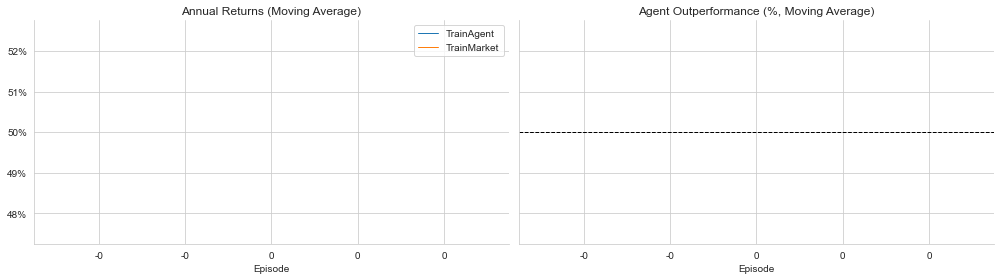

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['TrainAgent', 'TrainMarket']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(50).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'performance', dpi=300)


